In [1]:
%matplotlib inline
import os
import sys
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

cwd = os.getcwd()
# Add directories for modules and data files
dirs = [x[0] for x in os.walk(cwd)]
[sys.path.append(d) for d in dirs]
data_dir = cwd+'\\Input\\DataFiles\\' # Manual way; TODO: find a relative way to do this automatically
vegas_dir = cwd+'\\Input\\VegasOdds\\'
elo_out_dir = cwd+'\\Output\\TestElos\\'
import elo

In [2]:
elos = pd.read_csv(elo_out_dir+'SeasonElosK65HCA130.csv', index_col=0)
elos.tail()

,Season,SeasonElo,TeamID
56457,2014,1421.374237,1464
61343,2015,1326.146598,1464
66937,2016,1310.413851,1464
72302,2017,1280.965553,1464
81686,2018,1154.596226,1464


In [3]:
### Load Regular Season Results
# Start at 2003 because advanced stats can only be calculated that far back

start = 2003
rs = pd.read_csv(data_dir+'RegularSeasonDetailedResults.csv')
rs = rs.loc[rs.Season>=start]
rs = rs.drop(['NumOT'], axis=1)
rs = rs.reset_index(drop=True)
rs = rs.drop('DayNum', axis=1)
rs['GameID'] = rs.index.values
rs.tail()

,Season,WTeamID,WScore,LTeamID,LScore,WLoc,WFGM,WFGA,WFGM3,WFGA3,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,GameID
82036,2018,1153,56,1222,55,N,20,46,4,14,...,10,12,9,20,12,12,8,2,19,82036
82037,2018,1172,58,1348,57,N,19,50,6,18,...,9,17,11,26,12,14,3,4,16,82037
82038,2018,1209,74,1426,61,N,25,56,8,17,...,23,28,19,24,9,13,1,5,16,82038
82039,2018,1246,77,1397,72,N,25,50,7,16,...,16,20,18,16,14,10,4,3,21,82039
82040,2018,1335,68,1217,65,N,24,52,8,18,...,12,12,5,29,6,8,2,2,17,82040


In [4]:
rs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82041 entries, 0 to 82040
Data columns (total 33 columns):
Season     82041 non-null int64
WTeamID    82041 non-null int64
WScore     82041 non-null int64
LTeamID    82041 non-null int64
LScore     82041 non-null int64
WLoc       82041 non-null object
WFGM       82041 non-null int64
WFGA       82041 non-null int64
WFGM3      82041 non-null int64
WFGA3      82041 non-null int64
WFTM       82041 non-null int64
WFTA       82041 non-null int64
WOR        82041 non-null int64
WDR        82041 non-null int64
WAst       82041 non-null int64
WTO        82041 non-null int64
WStl       82041 non-null int64
WBlk       82041 non-null int64
WPF        82041 non-null int64
LFGM       82041 non-null int64
LFGA       82041 non-null int64
LFGM3      82041 non-null int64
LFGA3      82041 non-null int64
LFTM       82041 non-null int64
LFTA       82041 non-null int64
LOR        82041 non-null int64
LDR        82041 non-null int64
LAst       82041 non-null 

In [5]:
### Load the dataframe template for training/testing data

elo_train = pd.read_csv(cwd+'\\Output\\EloTrain.csv', index_col=0)
elo_train.drop(['DayNum', 'WScore', 'LScore'], axis=1, inplace=True)
elo_train.tail(10)

,Season,WTeamID,LTeamID,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
2086,2018,1437,1452,-12,2188.106007,2000.901961,-187.204046
2087,2018,1181,1393,-4,2082.803818,1804.624142,-278.179676
2088,2018,1403,1345,-13,1973.857023,2063.320969,89.463946
2089,2018,1260,1243,-16,1890.909689,1883.675788,-7.233901
2090,2018,1276,1199,-4,2153.645824,1844.356725,-309.289099
2091,2018,1437,1403,-12,2188.106007,1973.857023,-214.248984
2092,2018,1242,1181,-4,2084.816709,2082.803818,-2.012891
2093,2018,1276,1260,-12,2153.645824,1890.909689,-262.736135
2094,2018,1437,1242,-16,2188.106007,2084.816709,-103.289298
2095,2018,1437,1276,-17,2188.106007,2153.645824,-34.460183


In [6]:
elo_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 7 columns):
Season           2096 non-null int64
WTeamID          2096 non-null int64
LTeamID          2096 non-null int64
WMargin          2096 non-null int64
WSeasonElo       2096 non-null float64
LSeasonElo       2096 non-null float64
SeasonEloDiff    2096 non-null float64
dtypes: float64(3), int64(4)
memory usage: 131.0 KB


In [7]:
### Load the data to evaluate odds with

odds_tourney = pd.read_csv(cwd+'\\Output\\EloLines1718.csv', index_col=0)
line_cols = [col for col in odds_tourney if col.startswith('line')]
line_cols.remove('lineavg')
odds_tourney.drop(line_cols+['DayNum', 'homeID', 'neutral', 'roadID', 'favoriteID', 'underdogID', 'PredBetWATS',
                            'PredBetLATS', 'hscore', 'rscore', 'WScore', 'LScore',
                            'homewins', 'favwins'], axis=1, inplace=True)
odds_tourney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 0 to 267
Data columns (total 19 columns):
LTeamID              268 non-null int64
WTeamID              268 non-null int64
date                 268 non-null object
home                 268 non-null object
lineavg              268 non-null float64
WMargin              268 non-null int64
road                 268 non-null object
std                  268 non-null float64
WinATS               268 non-null int64
LoseATS              268 non-null int64
Season               268 non-null int64
WSeasonElo           268 non-null float64
LSeasonElo           268 non-null float64
SeasonEloDiff        268 non-null float64
PredMargin           268 non-null int64
PredBet              268 non-null int64
PredBetWATSProfit    268 non-null int64
PredBetLATSProfit    268 non-null int64
PredBetProfit        268 non-null int64
dtypes: float64(5), int64(11), object(3)
memory usage: 41.9+ KB


In [8]:
odds_tourney.tail(7)

,LTeamID,WTeamID,date,home,lineavg,WMargin,road,std,WinATS,LoseATS,Season,WSeasonElo,LSeasonElo,SeasonEloDiff,PredMargin,PredBet,PredBetWATSProfit,PredBetLATSProfit,PredBetProfit
261,1243,1260,2018-03-24,Kansas St.,-2.06,16,Loyola-Chicago,2.33,-1,1,2018,1890.909689,1883.675788,7.233901,0,1,-120,-116,26
262,1199,1276,2018-03-24,Michigan,-4.72,-4,Florida St.,2.88,-1,1,2018,2153.645824,1844.356725,-309.289099,-9,-1,-121,-117,25
263,1181,1242,2018-03-25,Kansas,2.80,-4,Duke,2.04,1,-1,2018,2084.816709,2082.803818,-2.012891,0,1,-120,-118,26
264,1403,1437,2018-03-25,Villanova,-6.23,-12,Texas Tech,1.79,1,-1,2018,2188.106007,1973.857023,-214.248984,-6,-1,-121,-119,25
265,1260,1276,2018-03-31,Michigan,-6.59,-12,Loyola-Chicago,2.38,1,-1,2018,2153.645824,1890.909689,-262.736135,-7,1,-120,-120,26
266,1242,1437,2018-03-31,Villanova,-4.60,-16,Kansas,1.34,1,-1,2018,2188.106007,2084.816709,-103.289298,-3,-1,-121,-121,25
267,1276,1437,2018-04-02,Villanova,-4.79,-17,Michigan,3.30,1,-1,2018,2188.106007,2153.645824,-34.460183,-1,-1,-122,-122,24


In [9]:
# Get tourney teams by season
df_seeds = pd.read_csv(data_dir+"NCAATourneySeeds.csv")
teams_by_season = df_seeds.groupby('Season')['TeamID'].unique()
teams_by_season = dict(teams_by_season.loc[teams_by_season.index >= 2003])
teams_by_season

{2003: array([1328, 1448, 1393, 1257, 1280, 1329, 1386, 1143, 1301, 1120, 1335,
        1139, 1122, 1264, 1190, 1354, 1400, 1196, 1462, 1390, 1163, 1268,
        1277, 1261, 1345, 1160, 1423, 1140, 1360, 1407, 1358, 1411, 1421,
        1246, 1338, 1266, 1173, 1458, 1281, 1231, 1332, 1428, 1104, 1356,
        1451, 1409, 1221, 1447, 1237, 1112, 1242, 1181, 1228, 1323, 1166,
        1272, 1153, 1211, 1113, 1141, 1454, 1443, 1161, 1429, 1436], dtype=int64),
 2004: array([1181, 1280, 1400, 1153, 1228, 1314, 1462, 1371, 1112, 1257, 1102,
        1293, 1190, 1343, 1284, 1106, 1390, 1163, 1301, 1268, 1393, 1435,
        1177, 1104, 1356, 1173, 1444, 1140, 1431, 1418, 1436, 1427, 1386,
        1329, 1338, 1448, 1196, 1458, 1272, 1403, 1150, 1376, 1350, 1264,
        1433, 1416, 1186, 1251, 1246, 1211, 1210, 1242, 1344, 1130, 1277,
        1449, 1412, 1305, 1428, 1334, 1227, 1320, 1434, 1197, 1250], dtype=int64),
 2005: array([1449, 1448, 1211, 1257, 1210, 1403, 1452, 1334, 1338, 1166, 1417,
  

In [10]:
# Introduce the stat ledger, a dataframe that contains the statistics engineered from this project.

stat_ledger = df_seeds.copy().drop('Seed', axis=1)
stat_ledger = stat_ledger.loc[stat_ledger.Season >= 2003].reset_index(drop=True)
stat_ledger['SeasonElo'] = (stat_ledger
                            .apply(lambda row: elos.loc[((row[0] == elos.Season) & (row[1] == elos.TeamID)), 'SeasonElo']
                                   .values[0], axis=1))
df_teams = pd.read_csv(data_dir+'Teams.csv')
teams = dict(df_teams[['TeamID', 'TeamName']].values.tolist())
stat_ledger['TeamName'] = list(map(lambda x: teams[x], stat_ledger.TeamID.values))
stat_ledger.tail(10)

,Season,TeamID,SeasonElo,TeamName
1054,2018,1281,1843.791187,Missouri
1055,2018,1199,1844.356725,Florida St
1056,2018,1344,1846.201752,Providence
1057,2018,1361,1901.846808,San Diego St
1058,2018,1355,1843.036906,S Dakota St
1059,2018,1422,1788.932036,UNC Greensboro
1060,2018,1285,1724.822028,Montana
1061,2018,1252,1595.395973,Lipscomb
1062,2018,1300,1261.980266,NC Central
1063,2018,1411,1349.738990,TX Southern


### Evaluating Strength of Schedule
Before calculating advanced stats, it's important to evaluate the strength of the opposing teams each respective team faces. Some teams stats are inflated due to the weak competition they face.

In [11]:
rs_c = pd.read_csv(data_dir+'RegularSeasonCompactResults.csv')
rs_c = rs_c.loc[rs_c.Season >= 2003].reset_index(drop=True).sort_index()
rs_c['GameID'] = rs_c.index.values
# elo_history = elo.elo_history(rs_c, 65, 130) # For calculating the first time
# elo_history.reset_index(drop=True).rename({'SeasonElo':'Elo'}, axis=1)
# elo_history.to_csv(elo_out_dir+"EloHistory.csv")
elo_history = pd.read_csv(elo_out_dir + "EloHistory.csv")

In [12]:
elo_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164082 entries, 0 to 164081
Data columns (total 5 columns):
Unnamed: 0    164082 non-null int64
GameID        164082 non-null int64
Season        164082 non-null int64
SeasonElo     164082 non-null float64
TeamID        164082 non-null int64
dtypes: float64(1), int64(4)
memory usage: 6.3 MB


In [13]:
#### FOR CALCULATING ELO HISTORY FOR THE FIRST TIME #####

# def get_schedule(teamID, df_season, teamID_cols=['WTeamID', 'LTeamID']):
    
#     teams = (df_season.loc[(df_season.WTeamID==teamID)|(df_season.LTeamID==teamID), teamID_cols]).values
#     # flatten list
#     teams = list(itertools.chain(*teams))
    
#     # remove the current team's ID from list of teams
#     teams = list(filter(lambda team: team != teamID, teams))

#     return teams

# # Build dictionary of season schedules
# schedules = dict()
# for season in teams_by_season.keys():
#     season_schedule = dict()
#     for team in teams_by_season[season]:
#         df_season = rs_c.loc[(rs_c.Season==season)]
#         team_schedule = get_schedule(team, df_season)
#         season_schedule[team] = team_schedule
#     schedules[season] = season_schedule
    
# # Calculate Average Opponent Elo Ratings
# stat_ledger['AvgOppElo'] = None

# for season in schedules.keys():
#     for team in schedules[season].keys():
#         opps = schedules[season][team]
#         opp_elos = [elos.loc[(elos.Season==season) & (elos.TeamID==opp), 'SeasonElo'].values[0] for opp in opps]
#         avg_opp_elo = np.mean(opp_elos)
#         stat_ledger.loc[(stat_ledger.Season==season) & (stat_ledger.TeamID==team), 'AvgOppElo'] = avg_opp_elo
        
# avg_opp_elo_scaled = MinMaxScaler(feature_range=(0.8,1.2)).fit_transform(stat_ledger.AvgOppElo.values.reshape(-1,1))
# stat_ledger['AvgOppEloScaled'] = avg_opp_elo_scaled
# stat_ledger.to_csv(data_dir+"StatLedgerSOS.csv")
#### END FIRST TIME CALCULATION BLOCK ####

stat_ledger = pd.read_csv(data_dir+"StatLedgerSOS.csv", index_col=0)
stat_ledger.loc[stat_ledger.Season==2018].sort_values('SeasonElo', ascending=False).head(10)

,Season,TeamID,SeasonElo,TeamName,AvgOppElo,AvgOppEloScaled
1031,2018,1438,2244.277735,Virginia,1758.426180,1.152714
996,2018,1437,2188.106007,Villanova,1768.161718,1.158981
1049,2018,1276,2153.645824,Michigan,1687.280295,1.106912
1050,2018,1211,2142.204268,Gonzaga,1546.003073,1.015962
1032,2018,1153,2103.432764,Cincinnati,1621.588791,1.064622
1014,2018,1242,2084.816709,Kansas,1801.260035,1.180289
1015,2018,1181,2082.803818,Duke,1742.779756,1.142641
1048,2018,1314,2073.475159,North Carolina,1825.139222,1.195661
1035,2018,1246,2065.518294,Kentucky,1791.835849,1.174222
997,2018,1345,2063.320969,Purdue,1712.045961,1.122856


### Calculating Advanced Season Stats

In [14]:
# Tons of feature engineering was done in the following Kaggle kernel:
# Main difference is I didn't scale anything to 100 possessions because it seems unnecessary, so everything is per possession
# https://www.kaggle.com/lnatml/feature-engineering-with-advanced-stats
def calculate_advanced_stats(df):
    #Points Winning/Losing Team
    df['WPts'] = df.apply(lambda row: 2*row.WFGM + row.WFGM3 + row.WFTM, axis=1)
    df['LPts'] = df.apply(lambda row: 2*row.LFGM + row.LFGM3 + row.LFTM, axis=1)

    #Calculate Winning/losing Team Possession Feature
    wPos = df.apply(lambda row: 0.96*(row.WFGA + row.WTO + 0.44*row.WFTA - row.WOR), axis=1)
    lPos = df.apply(lambda row: 0.96*(row.LFGA + row.LTO + 0.44*row.LFTA - row.LOR), axis=1)
    
    #Define a useful possession as a shot attempt weighted by efficiency or an offensive rebound minus a turnover
    wUsefulPos = df.apply(lambda row: 0.96*(row.WFGA - row.WTO + 1.5*row.WFGA3 + 0.5*row.WFTA), axis=1)
    lUsefulPos = df.apply(lambda row: 0.96*(row.LFGA - row.LTO + 1.5*row.LFGA3 + 0.5*row.LFTA), axis=1)
    
    df['WUsefulPosMargin'] = wUsefulPos - lUsefulPos
    df['LUsefulPosMargin'] = -df['WUsefulPosMargin']
    df['WPos'] = wPos
    df['LPos'] = lPos
    #two teams use almost the same number of possessions in a game
    #(plus/minus one or two - depending on how quarters end)
    #so let's just take the average
    df['Pos'] = (wPos+lPos)/2
    #Offensive efficiency (OffRtg) =(Points / Possessions)
    df['WOffRtg'] = df.apply(lambda row: (row.WPts / row.WPos), axis=1)
    df['LOffRtg'] = df.apply(lambda row: (row.LPts / row.WPos), axis=1)
    #Defensive efficiency (DefRtg) = (Opponent points / Opponent possessions)
    df['WDefRtg'] = df.LOffRtg
    df['LDefRtg'] = df.WOffRtg
    #Net Rating = Off.Rtg - Def.Rtg
    df['WNetRtg'] = df.apply(lambda row:(row.WOffRtg - row.WDefRtg), axis=1)
    df['LNetRtg'] = df.apply(lambda row:(row.LOffRtg - row.LDefRtg), axis=1)
    #Tempo adjusted net rating
    df['WAdjNetRtg'] = df['WNetRtg'] * wPos
    df['LAdjNetRtg'] = df['LNetRtg'] * lPos
    #Assist Ratio : Percentage of team possessions that end in assists
    df['WAstR'] = df.apply(lambda row: row.WAst / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
    df['LAstR'] = df.apply(lambda row: row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
    #Turnover Ratio: Number of turnovers of a team per 100 possessions used.
    #(TO * 100) / (FGA + (FTA * 0.44) + AST + TO)
    df['WTOR'] = df.apply(lambda row: row.WTO / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
    df['LTOR'] = df.apply(lambda row: row.LTO / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)

    #The Shooting Percentage : Measure of Shooting Efficiency (FGA/FGA3, FTA)
    df['WTSP'] = df.apply(lambda row: row.WPts / (2 * (row.WFGA + 0.44 * row.WFTA)), axis=1)
    df['LTSP'] = df.apply(lambda row: row.LPts / (2 * (row.LFGA + 0.44 * row.LFTA)), axis=1)
    #eFG% : Effective Field Goal Percentage adjusting for the fact that 3pt shots are more valuable 
    df['WeFGP'] = df.apply(lambda row:(row.WFGM + 0.5 * row.WFGM3) / row.WFGA, axis=1)      
    df['LeFGP'] = df.apply(lambda row:(row.LFGM + 0.5 * row.LFGM3) / row.LFGA, axis=1)   
    #FTA Rate : How good a team is at drawing fouls.
    df['WFTAR'] = df.apply(lambda row: row.WFTA / row.WFGA, axis=1)
    df['LFTAR'] = df.apply(lambda row: row.LFTA / row.LFGA, axis=1)
    
    #TPA Rate : How reliant a team is on three point shooting
    df['WTPAR'] = df.apply(lambda row: row.WFGA3 / row.WFGA, axis=1)
    df['LTPAR'] = df.apply(lambda row: row.LFGA3 / row.LFGA, axis=1)


    #OREB% : Percentage of team offensive rebounds
    df['WORP'] = df.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
    df['LORP'] = df.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
    #DREB% : Percentage of team defensive rebounds
    df['WDRP'] = df.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
    df['LDRP'] = df.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)                                      
    #REB% : Percentage of team total rebounds
    df['WRP'] = df.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
    df['LRP'] = df.apply(lambda row: (row.LDR + row.LOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1) 
    
    df.to_csv(data_dir+'NCAATourneyDetailedResultsEnriched.csv', index=False)
    return df
    
# rs = calculate_advanced_stats(rs) # For calculating stats for the first time
rs = pd.read_csv(data_dir+'NCAATourneyDetailedResultsEnriched.csv') # For reading in stats if already calculated
rs.tail()

,Season,WTeamID,WScore,LTeamID,LScore,WLoc,WFGM,WFGA,WFGM3,WFGA3,...,WFTAR,LFTAR,WTPAR,LTPAR,WORP,LORP,WDRP,LDRP,WRP,LRP
82036,2018,1153,56,1222,55,N,20,46,4,14,...,0.413043,0.218182,0.304348,0.418182,0.310345,0.272727,0.727273,0.689655,0.532258,0.467742
82037,2018,1172,58,1348,57,N,19,50,6,18,...,0.320000,0.326923,0.360000,0.442308,0.187500,0.297297,0.702703,0.812500,0.463768,0.536232
82038,2018,1209,74,1426,61,N,25,56,8,17,...,0.357143,0.491228,0.303571,0.438596,0.250000,0.452381,0.547619,0.750000,0.418919,0.581081
82039,2018,1246,77,1397,72,N,25,50,7,16,...,0.480000,0.322581,0.320000,0.435484,0.407407,0.461538,0.538462,0.592593,0.484848,0.515152
82040,2018,1335,68,1217,65,N,24,52,8,18,...,0.307692,0.218182,0.346154,0.327273,0.093750,0.156250,0.843750,0.906250,0.468750,0.531250


In [15]:
rs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82041 entries, 0 to 82040
Data columns (total 66 columns):
Season              82041 non-null int64
WTeamID             82041 non-null int64
WScore              82041 non-null int64
LTeamID             82041 non-null int64
LScore              82041 non-null int64
WLoc                82041 non-null object
WFGM                82041 non-null int64
WFGA                82041 non-null int64
WFGM3               82041 non-null int64
WFGA3               82041 non-null int64
WFTM                82041 non-null int64
WFTA                82041 non-null int64
WOR                 82041 non-null int64
WDR                 82041 non-null int64
WAst                82041 non-null int64
WTO                 82041 non-null int64
WStl                82041 non-null int64
WBlk                82041 non-null int64
WPF                 82041 non-null int64
LFGM                82041 non-null int64
LFGA                82041 non-null int64
LFGM3               82041 non

In [16]:
stat_ledger.tail()

,Season,TeamID,SeasonElo,TeamName,AvgOppElo,AvgOppEloScaled
1059,2018,1422,1788.932036,UNC Greensboro,1410.728192,0.928877
1060,2018,1285,1724.822028,Montana,1414.560746,0.931344
1061,2018,1252,1595.395973,Lipscomb,1395.887018,0.919322
1062,2018,1300,1261.980266,NC Central,1215.968884,0.803497
1063,2018,1411,1349.738990,TX Southern,1354.015746,0.892367


In [17]:
# Choose which stats to save

def create_stat_ledger(stat_ledger, rs, stat_strs, teams_by_season):
    w_stats = ['W' + stat for stat in stat_strs]
    l_stats = ['L' + stat for stat in stat_strs]

    # Add opponent stats as well, which serve as proxies for defensive stats
    ostat_strs = ['o' + stat for stat in stat_strs]
    n_advstats = len(stat_strs)
    stat_cols = w_stats + l_stats

    # Initialize stat ledger format
    stat_ledger = stat_ledger.reindex(columns=list(stat_ledger.columns)+list(stat_strs)+list(ostat_strs))
    for season in teams_by_season:
        for team in teams_by_season[season]:
            # Break up into stats where team won and lost
            df_wins = rs.loc[(rs.Season==season) & (rs.WTeamID==team), w_stats]
            df_wins.columns = stat_strs
            df_losses = rs.loc[(rs.Season==season) & (rs.LTeamID==team), l_stats]
            df_losses.columns = stat_strs
            df_team = pd.concat([df_wins, df_losses])
            team_stats = df_team.apply(lambda col:col.mean()).values

            # Do the same for opponent's stats
            df_opp_wins = rs.loc[(rs.Season==season) & (rs.LTeamID==team), w_stats]
            df_opp_wins.columns = ostat_strs
            df_opp_losses = rs.loc[(rs.Season==season) & (rs.WTeamID==team), l_stats]
            df_opp_losses.columns = ostat_strs
            df_opp = pd.concat([df_opp_wins, df_opp_losses])
            opp_stats = df_opp.apply(lambda col:col.mean()).values
            
            # Assign the team's stats to the ledger
            stat_ledger.loc[(stat_ledger.Season==season) & (stat_ledger.TeamID==team), stat_strs] = team_stats
            stat_ledger.loc[(stat_ledger.Season==season) & (stat_ledger.TeamID==team), ostat_strs] = opp_stats
    return stat_ledger
# For calculating the 1st time

stat_strs = ['OffRtg', 'DefRtg', 'NetRtg', 'AstR', 'TOR', 'TSP', 'eFGP', 'FTAR', 
                                   'TPAR', 'ORP', 'DRP', 'RP', 'Pos']
# # stat_ledger = stat_ledger.reindex(columns=list(stat_ledger.columns)+list(stat_strs)+list(ostat_strs))
# stat_ledger = create_stat_ledger(stat_ledger=stat_ledger.copy(), 
#                                  rs=rs,
#                                  stat_strs=stat_strs,
#                                 teams_by_season=teams_by_season)
# stat_ledger.to_csv(data_dir+'StatLedger.csv')
stat_ledger = pd.read_csv(data_dir+'StatLedger.csv', index_col=0)
stat_ledger.tail()

,Season,TeamID,SeasonElo,TeamName,AvgOppElo,AvgOppEloScaled,OffRtg,DefRtg,NetRtg,AstR,...,oAstR,oTOR,oTSP,oeFGP,oFTAR,oTPAR,oORP,oDRP,oRP,oPos
1059,2018,1422,1788.932036,UNC Greensboro,1410.728192,0.928877,1.120640,0.986348,0.134292,0.149231,...,0.120120,0.172759,0.530397,0.480133,0.404284,0.406768,0.232968,0.660243,0.454025,64.128000
1060,2018,1285,1724.822028,Montana,1414.560746,0.931344,1.158261,1.019536,0.138725,0.134255,...,0.112266,0.168925,0.538375,0.486782,0.426550,0.320280,0.259783,0.661110,0.462635,67.362271
1061,2018,1252,1595.395973,Lipscomb,1395.887018,0.919322,1.093036,1.057637,0.035399,0.145804,...,0.134624,0.156757,0.558420,0.520104,0.391743,0.366679,0.236097,0.721826,0.479478,73.953103
1062,2018,1300,1261.980266,NC Central,1215.968884,0.803497,1.089235,1.091230,-0.001995,0.157052,...,0.144844,0.124843,0.531192,0.488438,0.345442,0.379638,0.294522,0.675463,0.479639,64.383174
1063,2018,1411,1349.738990,TX Southern,1354.015746,0.892367,1.120484,1.150328,-0.029844,0.128992,...,0.156399,0.117521,0.547198,0.517176,0.316267,0.332652,0.317707,0.714219,0.510551,69.708424


In [18]:
stat_ledger['AdjNetRtg'] = stat_ledger.Pos * stat_ledger.NetRtg * stat_ledger.AvgOppEloScaled
stat_ledger.loc[stat_ledger.Season == 2018, ['TeamName', 'AdjNetRtg']].sort_values(['AdjNetRtg'], ascending=False)

,TeamName,AdjNetRtg
996,Villanova,18.850753
1032,Cincinnati,18.117188
1050,Gonzaga,17.819139
1016,Michigan St,17.370370
1015,Duke,17.359739
997,Purdue,16.730924
1031,Virginia,16.164979
1052,Houston,13.100801
999,Wichita St,12.387077
1014,Kansas,12.029720


In [19]:
# As a curiosity, observe these stats for the 2018 tournament.
stat_ledger.loc[stat_ledger.Season==2018].sort_values('SeasonElo', ascending=False)

,Season,TeamID,SeasonElo,TeamName,AvgOppElo,AvgOppEloScaled,OffRtg,DefRtg,NetRtg,AstR,...,oTOR,oTSP,oeFGP,oFTAR,oTPAR,oORP,oDRP,oRP,oPos,AdjNetRtg
1031,2018,1438,2244.277735,Virginia,1758.426180,1.152714,1.167120,0.924750,0.242370,0.165591,...,0.163380,0.477503,0.436527,0.266843,0.404041,0.252662,0.726215,0.482196,57.847855,16.164979
996,2018,1437,2188.106007,Villanova,1768.161718,1.158981,1.291897,1.050726,0.241170,0.171200,...,0.139751,0.529516,0.493855,0.256082,0.354911,0.263354,0.716237,0.478647,67.711624,18.850753
1049,2018,1276,2153.645824,Michigan,1687.280295,1.106912,1.169736,1.014878,0.154858,0.163273,...,0.151524,0.522470,0.485194,0.308346,0.303048,0.245891,0.742378,0.494639,63.134118,10.759939
1050,2018,1211,2142.204268,Gonzaga,1546.003073,1.015962,1.263839,1.002488,0.261351,0.160725,...,0.137204,0.508320,0.469315,0.296780,0.355978,0.224279,0.676097,0.436905,66.985412,17.819139
1032,2018,1153,2103.432764,Cincinnati,1621.588791,1.064622,1.179592,0.910168,0.269424,0.165718,...,0.172061,0.466702,0.428539,0.283043,0.374678,0.288360,0.617518,0.448959,63.088941,18.117188
1014,2018,1242,2084.816709,Kansas,1801.260035,1.180289,1.220603,1.068139,0.152464,0.175403,...,0.138482,0.519337,0.487219,0.251098,0.383608,0.316237,0.709943,0.499466,66.811482,12.029720
1015,2018,1181,2082.803818,Duke,1742.779756,1.142641,1.247000,1.022543,0.224456,0.170226,...,0.125972,0.492246,0.459770,0.222938,0.368458,0.290548,0.611537,0.438236,68.028509,17.359739
1048,2018,1314,2073.475159,North Carolina,1825.139222,1.195661,1.197287,1.074025,0.123262,0.174681,...,0.121226,0.529969,0.502055,0.263589,0.409956,0.258745,0.617998,0.432478,67.936183,10.085320
1035,2018,1246,2065.518294,Kentucky,1791.835849,1.174222,1.157699,1.062769,0.094930,0.140032,...,0.127049,0.510677,0.471966,0.331817,0.424007,0.310479,0.651515,0.468666,66.329224,7.423747
997,2018,1345,2063.320969,Purdue,1712.045961,1.122856,1.245098,1.016671,0.228427,0.177639,...,0.134089,0.499033,0.469871,0.244167,0.347082,0.279848,0.722939,0.482199,64.984094,16.730924


In [20]:
ostat_strs = ['o' + stat for stat in stat_strs]
stats = stat_strs+ostat_strs+['SeasonElo', 'AdjNetRtg']
scaled = RobustScaler().fit_transform(stat_ledger[stats])
stat_ledger_scaled = stat_ledger.copy()
stat_ledger_scaled[stats] = scaled

stat_ledger_scaled.loc[stat_ledger.Season==2018].sort_values('AdjNetRtg', ascending=False).head()


,Season,TeamID,SeasonElo,TeamName,AvgOppElo,AvgOppEloScaled,OffRtg,DefRtg,NetRtg,AstR,...,oTOR,oTSP,oeFGP,oFTAR,oTPAR,oORP,oDRP,oRP,oPos,AdjNetRtg
996,2018,1437,1.436123,Villanova,1768.161718,1.158981,2.198605,0.413820,1.449558,0.840270,...,-0.523825,0.545707,0.619602,-1.091839,0.429505,-1.032238,1.011476,-0.024907,0.731177,1.860846
1032,2018,1153,1.123051,Cincinnati,1621.588791,1.064622,0.516108,-1.751822,1.789504,0.574432,...,0.641786,-1.504411,-1.374551,-0.739822,0.815431,-0.426807,-0.794929,-1.035236,-0.325791,1.733982
1050,2018,1211,1.266405,Gonzaga,1546.003073,1.015962,1.778255,-0.329409,1.692366,0.332276,...,-0.615719,-0.146088,-0.129614,-0.560466,0.450322,-1.978266,0.276968,-1.445471,0.565130,1.682437
1016,2018,1277,0.921013,Michigan St,1674.760544,1.098852,1.455348,-0.371828,1.466165,1.914241,...,-1.642880,-1.297952,-1.409559,-0.549054,0.523095,-1.087415,-0.523027,-1.891074,0.140070,1.604826
1015,2018,1181,1.046777,Duke,1742.779756,1.142641,1.525980,-0.020404,1.248461,0.793035,...,-1.020921,-0.670730,-0.421020,-1.524579,0.693990,-0.373849,-0.904370,-1.400167,0.803632,1.602988


In [21]:
# Dump raw stats from stat ledger into tourney_matchups
stat_strs = ['OffRtg', 'DefRtg', 'NetRtg', 'AstR', 'TOR', 'TSP', 'eFGP', 'FTAR', 
                                   'TPAR', 'ORP', 'DRP', 'RP', 'Pos']
diff_cols = [stat+'diff' for stat in stat_strs]
odiff_cols = ['o'+stat+'diff' for stat in stat_strs]
stat_ledger_cols = list(stat_strs)+list(ostat_strs)
all_diff_cols = diff_cols + odiff_cols
#### FOR FIRST TIME CALCULATIONS OF TOURNEY_MATCHUPS ####
# tourney_matchups = elo_train.copy().drop(['WSeasonElo', 'LSeasonElo'], axis=1)

# tourney_matchups = tourney_matchups.reindex(columns=list(tourney_matchups.columns)+all_diff_cols)
# mirror_limit = len(elo_train) // 2
# #print(tourney_matchups)

# for i, row in tourney_matchups.copy()[:mirror_limit].iterrows():
#     '''
#     iterate over tournament matchups between teams
#     look up stats for each team through stat_ledger, which contains season stats for all teams
#     assign stats to corresponding team ID
#     '''
#     season = row.Season
#     w_team = row.WTeamID
#     l_team = row.LTeamID
    
#     # Get values for winning team's stats and opponent's performance
#     w_team_arr = stat_ledger.loc[(stat_ledger.Season==season) & (stat_ledger.TeamID==w_team), stat_strs].values[0]
#     w_opp_arr = stat_ledger.loc[(stat_ledger.Season==season) & (stat_ledger.TeamID==w_team), ostat_strs].values[0]
    
#     # Get values for losing team's stats and opponent's performance
#     l_team_arr = stat_ledger.loc[(stat_ledger.Season==season) & (stat_ledger.TeamID==l_team), stat_strs].values[0]
#     l_opp_arr = stat_ledger.loc[(stat_ledger.Season==season) & (stat_ledger.TeamID==l_team), ostat_strs].values[0]
    
#     # Take the difference between winning team and losing team
#     wl_team_diff = w_team_arr - l_team_arr
#     wl_opp_diff = w_opp_arr - l_opp_arr

#     # Assign the differences in stats to the tourney_matchups dataframe
#     tourney_matchups.loc[i, diff_cols] = wl_team_diff
#     tourney_matchups.loc[i, odiff_cols] = wl_opp_diff
    
#     # Because this dataframe's 2nd half is a mirror of the 1st half, assign the negative values to the 2nd half
#     tourney_matchups.loc[i+mirror_limit, diff_cols] = -wl_team_diff
#     tourney_matchups.loc[i+mirror_limit, odiff_cols] = -wl_opp_diff
tourney_matchups = pd.read_csv(data_dir+"TourneyMatchups.csv", index_col=0)

In [22]:
tourney_matchups.tail()

,Season,WTeamID,LTeamID,WMargin,SeasonEloDiff,OffRtgdiff,DefRtgdiff,NetRtgdiff,AstRdiff,TORdiff,...,oAstRdiff,oTORdiff,oTSPdiff,oeFGPdiff,oFTARdiff,oTPARdiff,oORPdiff,oDRPdiff,oRPdiff,oPosdiff
2091,2018,1437,1403,-12,-214.248984,-0.138949,-0.056446,-0.082503,-0.018258,0.028211,...,-0.031802,0.032267,-0.016478,-0.027487,0.133758,0.033156,0.019683,-0.046671,-0.009300,-2.015042
2092,2018,1242,1181,-4,-2.012891,0.026397,-0.045596,0.071993,-0.005177,0.004131,...,0.012035,-0.012510,-0.027091,-0.027449,-0.028160,-0.015150,-0.025689,-0.098406,-0.061230,1.217027
2093,2018,1276,1260,-12,-262.736135,-0.026643,-0.027761,0.001118,0.013007,0.039312,...,0.011228,0.001396,-0.015854,-0.010627,-0.046196,0.060428,0.007266,0.035428,-0.004906,-0.171318
2094,2018,1437,1242,-16,-103.289298,-0.071294,0.017413,-0.088707,0.004202,0.014512,...,-0.013062,-0.001269,-0.010179,-0.006636,-0.004983,0.028697,0.052884,-0.006294,0.020819,-0.900141
2095,2018,1437,1276,-17,-34.460183,-0.122160,-0.035848,-0.086312,-0.007927,-0.003339,...,-0.025187,0.011773,-0.007046,-0.008661,0.052264,-0.051864,-0.017463,0.026141,0.015993,-4.577506


In [23]:
# Dump scaled stats from scaled stat ledger into tourney_matchups_scaled
scaled_stat_strs = stat_strs + ['AdjNetRtg']
scaled_diff_cols = diff_cols + ['AdjNetRtgdiff']
stat_ledger_scaled_cols = list(stat_strs)+list(ostat_strs)
all_diff_cols = diff_cols + odiff_cols

### FOR FIRST TIME CALCULATION OF tourney_matchups_scaled ###
# tourney_matchups_scaled = tourney_matchups.copy()
# tourney_matchups_scaled = tourney_matchups_scaled.reindex(columns=list(tourney_matchups_scaled.columns)+['AdjNetRtgdiff'])
# mirror_limit = len(elo_train) // 2

# for i, row in tourney_matchups_scaled.copy()[:mirror_limit].iterrows():
#     '''
#     iterate over tournament matchups between teams
#     look up stats for each team through stat_ledger_scaled, which contains season stats for all teams
#     assign stats to corresponding team ID
#     '''
#     season = row.Season
#     w_team = row.WTeamID
#     l_team = row.LTeamID
    
#     # Get values for winning team's stats and opponent's performance
#     w_team_arr = stat_ledger_scaled.loc[(stat_ledger_scaled.Season==season) & (stat_ledger_scaled.TeamID==w_team), scaled_stat_strs].values[0]
#     w_opp_arr = stat_ledger_scaled.loc[(stat_ledger_scaled.Season==season) & (stat_ledger_scaled.TeamID==w_team), ostat_strs].values[0]
    
#     # Get values for losing team's stats and opponent's performance
#     l_team_arr = stat_ledger_scaled.loc[(stat_ledger_scaled.Season==season) & (stat_ledger_scaled.TeamID==l_team), scaled_stat_strs].values[0]
#     l_opp_arr = stat_ledger_scaled.loc[(stat_ledger_scaled.Season==season) & (stat_ledger_scaled.TeamID==l_team), ostat_strs].values[0]
    
#     # Take the difference between winning team and losing team
#     wl_team_diff = w_team_arr - l_team_arr
#     wl_opp_diff = w_opp_arr - l_opp_arr
    
#     # Assign the differences in stats to the tourney_matchups_scaled dataframe
#     tourney_matchups_scaled.loc[i, scaled_diff_cols] = wl_team_diff
#     tourney_matchups_scaled.loc[i, odiff_cols] = wl_opp_diff
    
#     # Because this dataframe's 2nd half is a mirror of the 1st half, assign the negative values to the 2nd half
#     tourney_matchups_scaled.loc[i+mirror_limit, scaled_diff_cols] = -wl_team_diff
#     tourney_matchups_scaled.loc[i+mirror_limit, odiff_cols] = -wl_opp_diff
tourney_matchups_scaled = pd.read_csv(data_dir+"TourneyMatchupsScaled.csv", index_col=0)

In [24]:
tourney_matchups_scaled.tail(10)

,Season,WTeamID,LTeamID,WMargin,SeasonEloDiff,OffRtgdiff,DefRtgdiff,NetRtgdiff,AstRdiff,TORdiff,...,oTORdiff,oTSPdiff,oeFGPdiff,oFTARdiff,oTPARdiff,oORPdiff,oDRPdiff,oRPdiff,oPosdiff,AdjNetRtgdiff
2086,2018,1437,1452,-12,-187.204046,-1.556851,-0.225791,-1.073985,-0.970314,0.325841,...,1.406835,0.495510,0.030474,2.507467,0.570305,0.825374,-1.499014,-0.116416,-0.221568,-1.240616
2087,2018,1181,1393,-4,-278.179676,-2.377103,0.240734,-2.097040,-2.206623,0.801913,...,0.556577,0.767153,0.357304,1.209535,1.409735,-0.092740,0.772091,1.005379,-1.232139,-2.384251
2088,2018,1403,1345,-13,89.463946,1.380555,0.344991,0.839318,1.197570,-0.961526,...,-1.368304,-0.457088,0.106941,-1.901954,-0.800217,-0.077177,0.976627,0.437389,-0.162909,0.871286
2089,2018,1260,1243,-16,-7.233901,-0.004459,1.317721,-1.032594,-0.855198,-0.655118,...,0.257574,1.198928,0.695022,1.515690,0.696165,1.711365,-0.727282,1.245655,0.110774,-0.786501
2090,2018,1276,1199,-4,-309.289099,-0.015780,0.843875,-0.671658,-0.556344,1.223262,...,-0.231334,0.227397,0.143921,0.097097,1.439527,1.169549,-1.154210,-0.516892,1.627816,-0.530070
2091,2018,1437,1403,-12,-214.248984,-2.081676,-0.869692,-0.992647,-0.885341,1.293411,...,1.164056,-0.537814,-0.839196,1.746397,0.647348,0.476526,-0.854001,-0.316497,-0.460736,-1.237892
2092,2018,1242,1181,-4,-2.012891,0.395465,-0.702515,0.866194,-0.251017,0.189391,...,-0.451320,-0.884211,-0.838033,-0.367674,-0.295789,-0.621954,-1.800678,-2.083790,0.278271,0.921782
2093,2018,1276,1260,-12,-262.736135,-0.399159,-0.427731,0.013452,0.630738,1.802376,...,0.050371,-0.517460,-0.324455,-0.603159,1.179797,0.175921,0.648285,-0.166964,-0.039171,-0.203403
2094,2018,1437,1242,-16,-103.289298,-1.068090,0.268290,-1.067291,0.203782,0.665323,...,-0.045775,-0.332226,-0.202589,-0.065065,0.560274,1.280343,-0.115167,0.708529,-0.205816,-1.179640
2095,2018,1437,1276,-17,-34.460183,-1.830154,-0.552323,-1.038485,-0.384403,-0.153103,...,0.424714,-0.229965,-0.264420,0.682382,-1.012595,-0.422785,0.478339,0.544263,-1.046638,-1.399238


In [25]:
odds_tourney.tail()

,LTeamID,WTeamID,date,home,lineavg,WMargin,road,std,WinATS,LoseATS,Season,WSeasonElo,LSeasonElo,SeasonEloDiff,PredMargin,PredBet,PredBetWATSProfit,PredBetLATSProfit,PredBetProfit
263,1181,1242,2018-03-25,Kansas,2.80,-4,Duke,2.04,1,-1,2018,2084.816709,2082.803818,-2.012891,0,1,-120,-118,26
264,1403,1437,2018-03-25,Villanova,-6.23,-12,Texas Tech,1.79,1,-1,2018,2188.106007,1973.857023,-214.248984,-6,-1,-121,-119,25
265,1260,1276,2018-03-31,Michigan,-6.59,-12,Loyola-Chicago,2.38,1,-1,2018,2153.645824,1890.909689,-262.736135,-7,1,-120,-120,26
266,1242,1437,2018-03-31,Villanova,-4.60,-16,Kansas,1.34,1,-1,2018,2188.106007,2084.816709,-103.289298,-3,-1,-121,-121,25
267,1276,1437,2018-04-02,Villanova,-4.79,-17,Michigan,3.30,1,-1,2018,2188.106007,2153.645824,-34.460183,-1,-1,-122,-122,24


### Training Data Using Advanced Stats

In [26]:
def simulate_betting(df, y_pred, model_name, line_col='lineavg', result_col='WMargin', commission=100.0):
    '''
    This function serves as the model for finding the running total of betting strategies.
    INPUT:
    df = dataframe containing stats and head to head matchups between teams
    y_pred = predicted winning margin of each head to head matchup in df
    model_name = the assigned name for the betting strategy
    line_col = the column containing the betting lines to compare to. Default is 'lineavg'
    result_col = the actual result for the game. Default is 'WMargin'
    commission = how much a betting platform takes a cut. This is usually a larger than 100, where 
                 commission - 100 = how much the casino makes in $if you place a $100 dollar bet.
    OUTPUT: 
    a copy of df with new columns,
    - 'PredMargin'+model_name = y_pred
    - 'PredBet'+model_name = the profitability of the betting model over time.
    '''
    win = 100.0/commission
    loss = -1.0
    pred_col = 'PredMargin'+model_name
    df[pred_col] = y_pred
    df['PredBet'+model_name] = (df[[line_col, pred_col, result_col]]
                                .apply(lambda x: win if (((x[1] < x[0]) & (x[2] < x[0])) |
                                                      ((x[1] >= x[0]) & (x[2] >= x[0]))) else loss, axis=1)
                               )
    return df

def plot_betting_strategy(data, x, y_preds, labels, linewidth=0.75, alpha=1.0):
    '''
    This function plots the profitability of betting strategies over time.
    data = head to head game data over time
    x = array of games or dates
    y_preds = a list of predictions of games
    labels = name for labels to assign different types of predictions
    '''
    model_names = dict(zip(y_preds, labels))
    plt.xlabel("Game")
    plt.ylabel("Profit")
    plt.title("Running Total of Betting 2017-18 Tournament Games")
    
    for y in y_preds:
        cumsum = np.cumsum(data[y])
        plt.plot(x, cumsum, label="Bets Based on {}".format(model_names[y]), linewidth=linewidth, alpha=alpha)


    plt.axvline(67, color='black', linestyle='--', label='2018 Tournament')
    plt.legend()

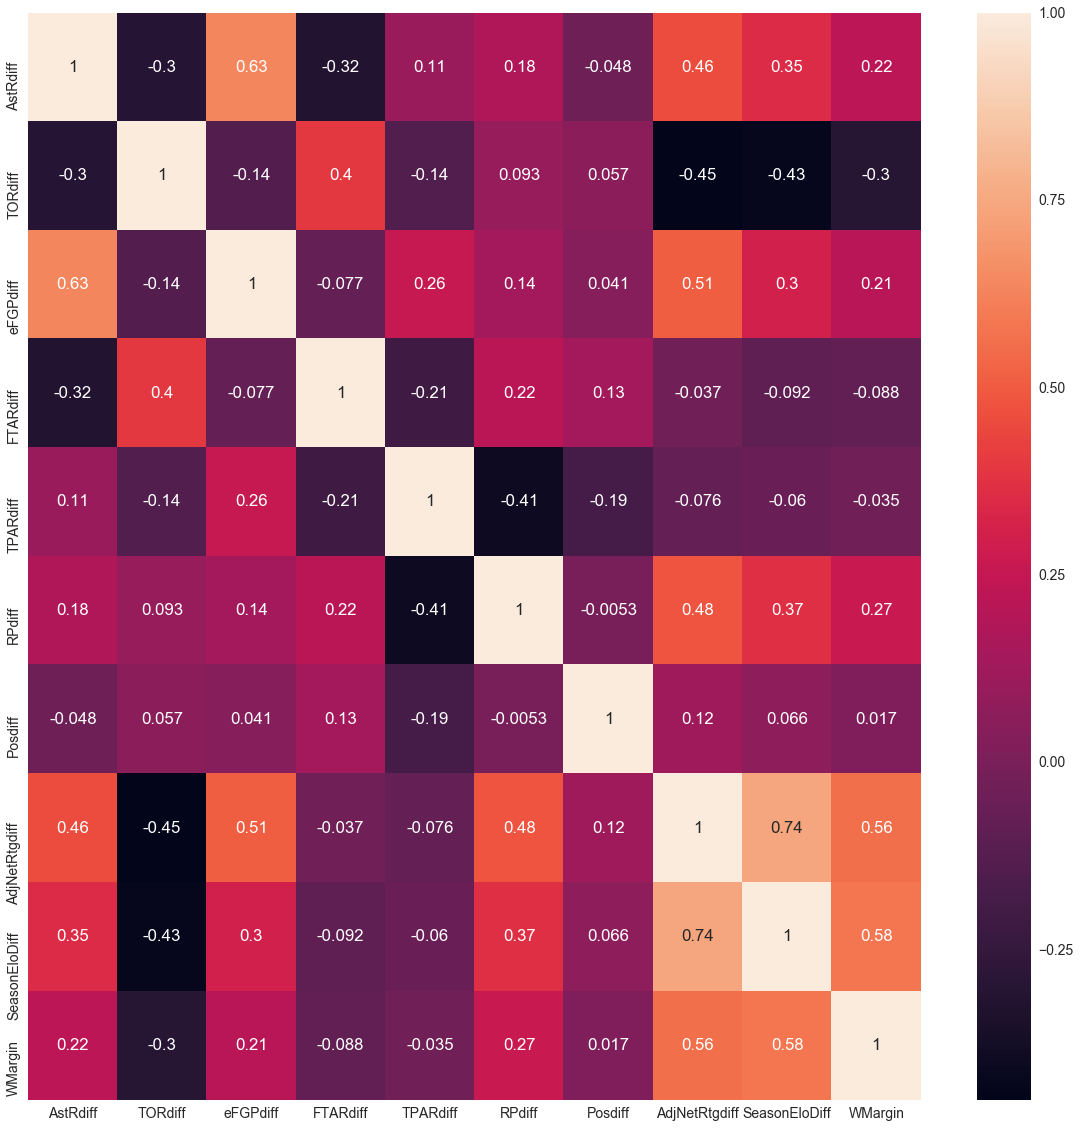

In [27]:
redundant_stats = ['oNetRtgdiff', 'oUsefulPossdiff', 'oORdiff', 'oODRdiff', 'oRPdiff', 'oDefRtgdiff', 
                   'oUsefulPosMargindiff', 'ORPdiff', 'DRPdiff', 'oOffRtgdiff', 'oPosdiff', 'OffRtgdiff', 'DefRtgdiff', 
                   'TSPdiff', 'UsefulPosMargindiff', 'NetRtgdiff']
useful_stats = scaled_diff_cols + ['SeasonEloDiff']
scaled_cols = [stat for stat in useful_stats if stat not in redundant_stats]
sns.set(font_scale=1.4)
plt.figure(figsize=(20,20))

### Heatmap to see how stats relate to one another
### KEY ROW: Bottom row shows how each stat is related to the predictor, WMargin
sns.heatmap(tourney_matchups_scaled[scaled_cols+['WMargin']].corr(), annot=True)
plt.savefig(cwd+'\\Documents\\stats_heatmap.png')

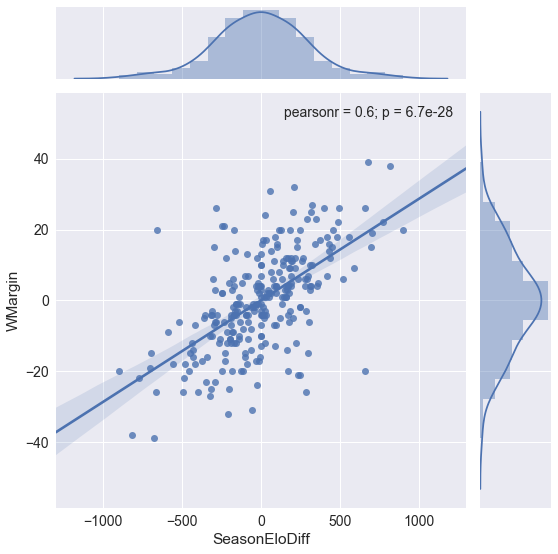

In [28]:
sns.jointplot(data=tourney_matchups_scaled.loc[tourney_matchups_scaled.Season >= 2017], x='SeasonEloDiff', y='WMargin', kind='reg', size=8)

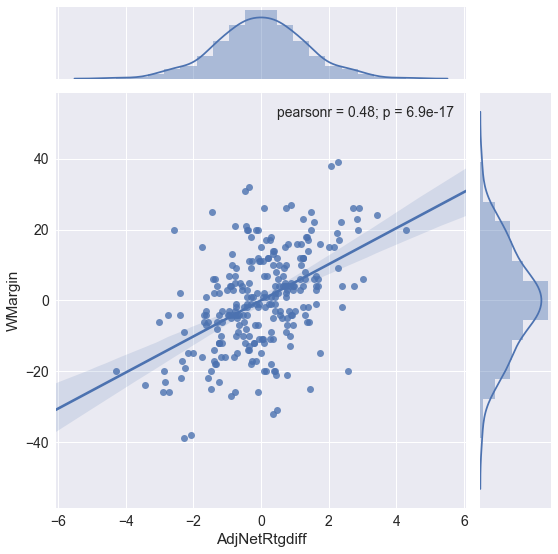

In [29]:
sns.jointplot(data=tourney_matchups_scaled.loc[tourney_matchups_scaled.Season >= 2017], x='AdjNetRtgdiff', y='WMargin', kind='reg', size=8)

In [30]:
odds_tourney.tail()

,LTeamID,WTeamID,date,home,lineavg,WMargin,road,std,WinATS,LoseATS,Season,WSeasonElo,LSeasonElo,SeasonEloDiff,PredMargin,PredBet,PredBetWATSProfit,PredBetLATSProfit,PredBetProfit
263,1181,1242,2018-03-25,Kansas,2.80,-4,Duke,2.04,1,-1,2018,2084.816709,2082.803818,-2.012891,0,1,-120,-118,26
264,1403,1437,2018-03-25,Villanova,-6.23,-12,Texas Tech,1.79,1,-1,2018,2188.106007,1973.857023,-214.248984,-6,-1,-121,-119,25
265,1260,1276,2018-03-31,Michigan,-6.59,-12,Loyola-Chicago,2.38,1,-1,2018,2153.645824,1890.909689,-262.736135,-7,1,-120,-120,26
266,1242,1437,2018-03-31,Villanova,-4.60,-16,Kansas,1.34,1,-1,2018,2188.106007,2084.816709,-103.289298,-3,-1,-121,-121,25
267,1276,1437,2018-04-02,Villanova,-4.79,-17,Michigan,3.30,1,-1,2018,2188.106007,2153.645824,-34.460183,-1,-1,-122,-122,24


In [31]:
tourney_matchups_scaled.tail()

,Season,WTeamID,LTeamID,WMargin,SeasonEloDiff,OffRtgdiff,DefRtgdiff,NetRtgdiff,AstRdiff,TORdiff,...,oTORdiff,oTSPdiff,oeFGPdiff,oFTARdiff,oTPARdiff,oORPdiff,oDRPdiff,oRPdiff,oPosdiff,AdjNetRtgdiff
2091,2018,1437,1403,-12,-214.248984,-2.081676,-0.869692,-0.992647,-0.885341,1.293411,...,1.164056,-0.537814,-0.839196,1.746397,0.647348,0.476526,-0.854001,-0.316497,-0.460736,-1.237892
2092,2018,1242,1181,-4,-2.012891,0.395465,-0.702515,0.866194,-0.251017,0.189391,...,-0.451320,-0.884211,-0.838033,-0.367674,-0.295789,-0.621954,-1.800678,-2.083790,0.278271,0.921782
2093,2018,1276,1260,-12,-262.736135,-0.399159,-0.427731,0.013452,0.630738,1.802376,...,0.050371,-0.517460,-0.324455,-0.603159,1.179797,0.175921,0.648285,-0.166964,-0.039171,-0.203403
2094,2018,1437,1242,-16,-103.289298,-1.068090,0.268290,-1.067291,0.203782,0.665323,...,-0.045775,-0.332226,-0.202589,-0.065065,0.560274,1.280343,-0.115167,0.708529,-0.205816,-1.179640
2095,2018,1437,1276,-17,-34.460183,-1.830154,-0.552323,-1.038485,-0.384403,-0.153103,...,0.424714,-0.229965,-0.264420,0.682382,-1.012595,-0.422785,0.478339,0.544263,-1.046638,-1.399238


In [32]:
scaled_cols

['AstRdiff',
 'TORdiff',
 'eFGPdiff',
 'FTARdiff',
 'TPARdiff',
 'RPdiff',
 'Posdiff',
 'AdjNetRtgdiff',
 'SeasonEloDiff']

#### First, recall the baselines

In [33]:
import warnings
warnings.filterwarnings('ignore')
mses = dict()
X_train = tourney_matchups.loc[tourney_matchups.Season < 2017, 'SeasonEloDiff'].values.reshape(-1,1)
y_train = tourney_matchups.loc[tourney_matchups.Season < 2017, 'WMargin'].values.reshape(-1,1)
X_test = tourney_matchups.loc[tourney_matchups.Season >= 2017, 'SeasonEloDiff'].values.reshape(-1,1)
y_true = tourney_matchups.loc[tourney_matchups.Season >= 2017, 'WMargin'].values.reshape(-1,1)


Linear Regression MSE:  123.72597937


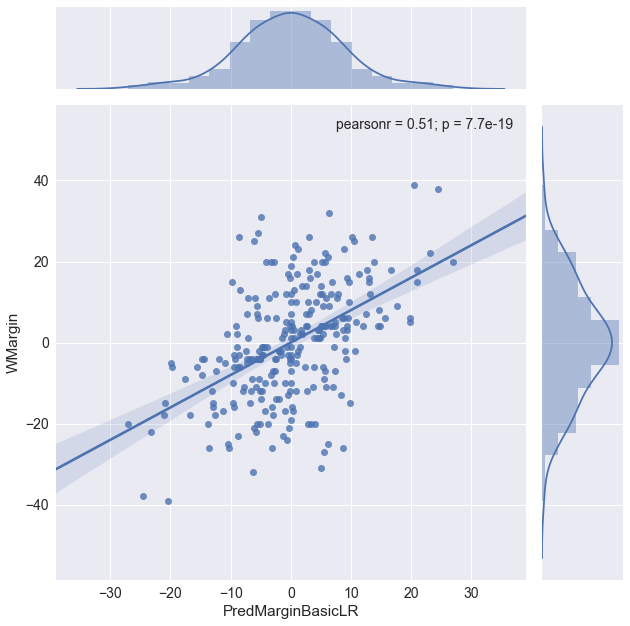

In [34]:
lr = lm.LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
odds_tourney = simulate_betting(odds_tourney, y_pred, 'BasicLR')
model_name = 'LRBasic'
mse = mean_squared_error(y_true, y_pred)
mses[model_name] = mse
print("Linear Regression MSE: ", mse)
sns.set(font_scale=1.4)
sns.jointplot(data=odds_tourney, x='PredMarginBasicLR', y='WMargin', kind='reg', size=9)

SVR MSE:  124.158687252


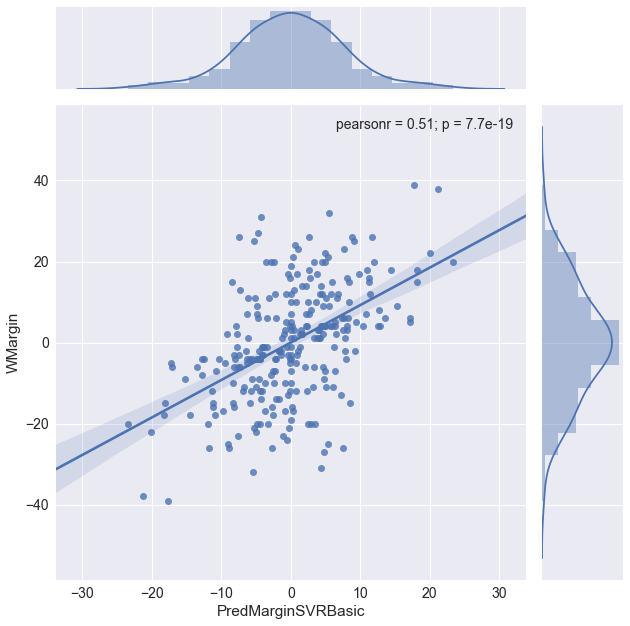

In [35]:
### SVR with Elo ratings as a feature
svr = LinearSVR()
C_s =  np.logspace(start=-2, stop=2, num=5)

parameters = {'C':C_s}
reg = GridSearchCV(svr,
                  parameters,
                  scoring='neg_mean_squared_error'
                  )

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
model_name = 'SVRBasic'
odds_tourney = simulate_betting(odds_tourney, y_pred, 'SVRBasic')
mse = mean_squared_error(y_true, y_pred)
mses[model_name] = mse
print("SVR MSE: ", mse)
sns.jointplot(data=odds_tourney, x='PredMarginSVRBasic', y='WMargin', kind='reg', size=9)

### Adding advanced stats to feature cols

In [36]:
# Split into train / test for advanced stats model
### SCALE STATS -> TRAIN/TEST SPLIT ###
X_train = tourney_matchups_scaled.loc[tourney_matchups_scaled.Season < 2017, scaled_cols].values
y_train = tourney_matchups_scaled.loc[tourney_matchups_scaled.Season < 2017, 'WMargin'].values.reshape(-1,1)
X_test = tourney_matchups_scaled.loc[tourney_matchups_scaled.Season >= 2017, scaled_cols].values
y_true = tourney_matchups_scaled.loc[tourney_matchups_scaled.Season >= 2017, 'WMargin'].values.reshape(-1,1)



#### Linear Regression With Scaled Elo & Advanced Stats

Linear Regression MSE:  132.294320324


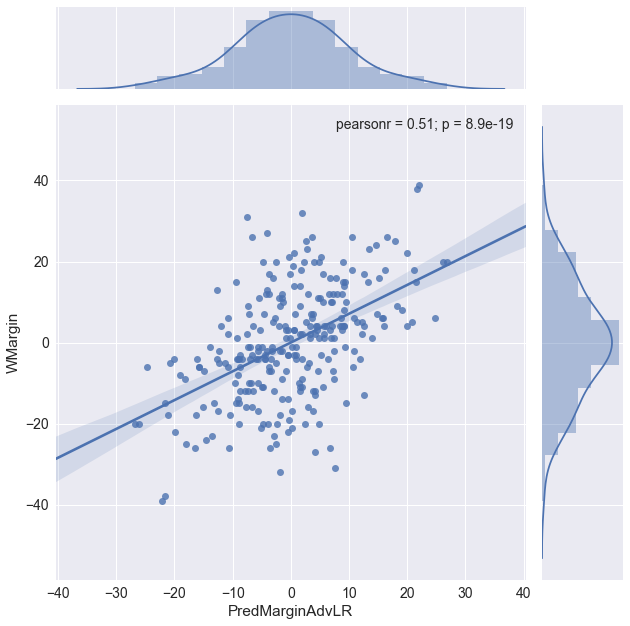

In [37]:
lr = lm.LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
odds_tourney = simulate_betting(odds_tourney, y_pred, 'AdvLR')
model_name = 'LRAdv'
mse = mean_squared_error(y_true, y_pred)
mses[model_name] = mse
print("Linear Regression MSE: ", mse)
sns.set(font_scale=1.4)
sns.jointplot(data=odds_tourney, x='PredMarginAdvLR', y='WMargin', kind='reg', size=9)

In [38]:
dict(zip(scaled_cols, lr.coef_.reshape(-1,1)))

{'AdjNetRtgdiff': array([ 4.6867032]),
 'AstRdiff': array([-0.75097755]),
 'FTARdiff': array([-1.13091026]),
 'Posdiff': array([-0.77905128]),
 'RPdiff': array([ 0.22327253]),
 'SeasonEloDiff': array([ 0.01703936]),
 'TORdiff': array([ 0.38684909]),
 'TPARdiff': array([ 0.12673679]),
 'eFGPdiff': array([-0.64045008])}

In [39]:
dict(list(zip(scaled_cols, lr.coef_)))

{'AstRdiff': array([-0.75097755,  0.38684909, -0.64045008, -1.13091026,  0.12673679,
         0.22327253, -0.77905128,  4.6867032 ,  0.01703936])}

#### Decision Tree Regression with Advanced Stats
##### Default Parameters

DTR MSE:  269.552238806


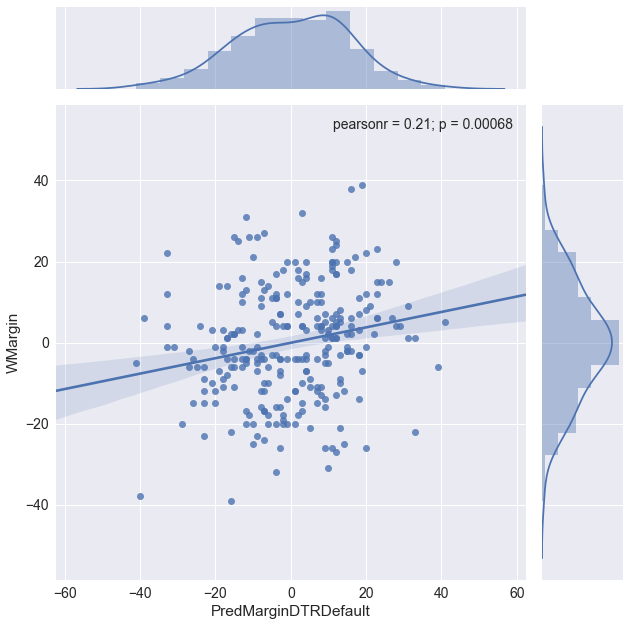

In [40]:
dtr = DecisionTreeRegressor(random_state=42018)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
odds_tourney = simulate_betting(odds_tourney, y_pred, 'DTRDefault')
mse = mean_squared_error(y_true, y_pred)
model_name = 'DTRDefault'
mses[model_name] = mse
print("DTR MSE: ", mse)
sns.jointplot(data=odds_tourney, x='PredMarginDTRDefault', y='WMargin', kind='reg', size=9)

##### Grid Search Parameters

DTR MSE:  130.833629449


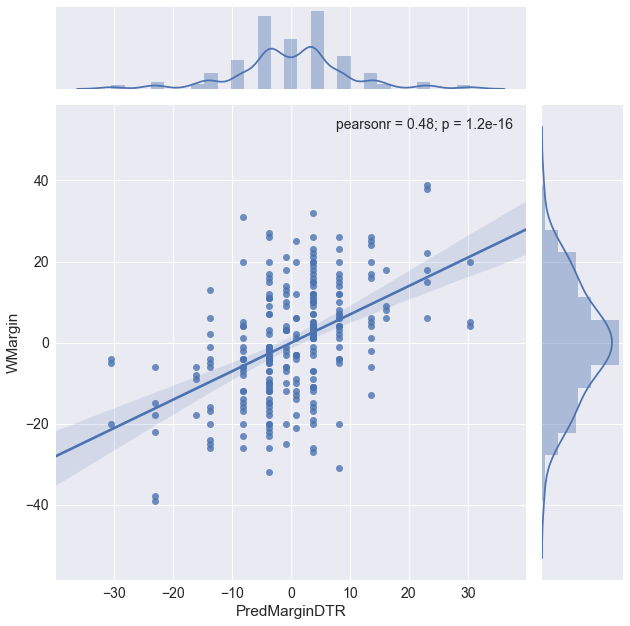

In [41]:
parameters = {'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(0.01,0.08,0.01),
             'max_depth':np.arange(2,5)}
dtr = DecisionTreeRegressor(random_state=42018)
reg = GridSearchCV(dtr,
                  parameters,
                  scoring='neg_mean_squared_error')

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
odds_tourney = simulate_betting(odds_tourney, y_pred, 'DTR')
mse = mean_squared_error(y_true, y_pred)
model_name = 'DTR'
mses[model_name] = mse
print("DTR MSE: ", mse)
sns.jointplot(data=odds_tourney, x='PredMarginDTR', y='WMargin', kind='reg', size=9)

In [42]:
print("Decision Tree Best Params: ", reg.best_params_)

Decision Tree Best Params:  {'min_samples_leaf': 0.01, 'min_samples_split': 2, 'max_depth': 4}


#### Linear Support Vector Regression with Advanced Stats

SVR with Advanced Stats MSE:  129.971753675


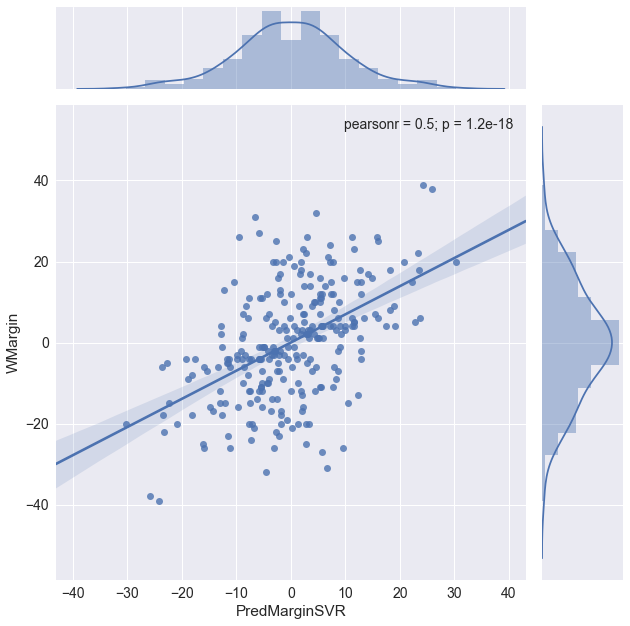

In [43]:

svr = LinearSVR(fit_intercept=False)
#C_s = [x*np.arange(1,10) for x in np.logspace(start=-1, stop=1, num=3)]
C_s =  np.logspace(start=-2, stop=2, num=5)

parameters = {'C':C_s}
reg = GridSearchCV(svr,
                  parameters,
                  scoring='neg_mean_squared_error'
                  )

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
odds_tourney = simulate_betting(odds_tourney, y_pred, 'SVR')
mse = mean_squared_error(y_true, y_pred)
mses['SVRAdv'] = mse
print("SVR with Advanced Stats MSE: ", mse)

sns.jointplot(data=odds_tourney, x='PredMarginSVR', y='WMargin', kind='reg', size=9)

## Simulate All Betting Strategies

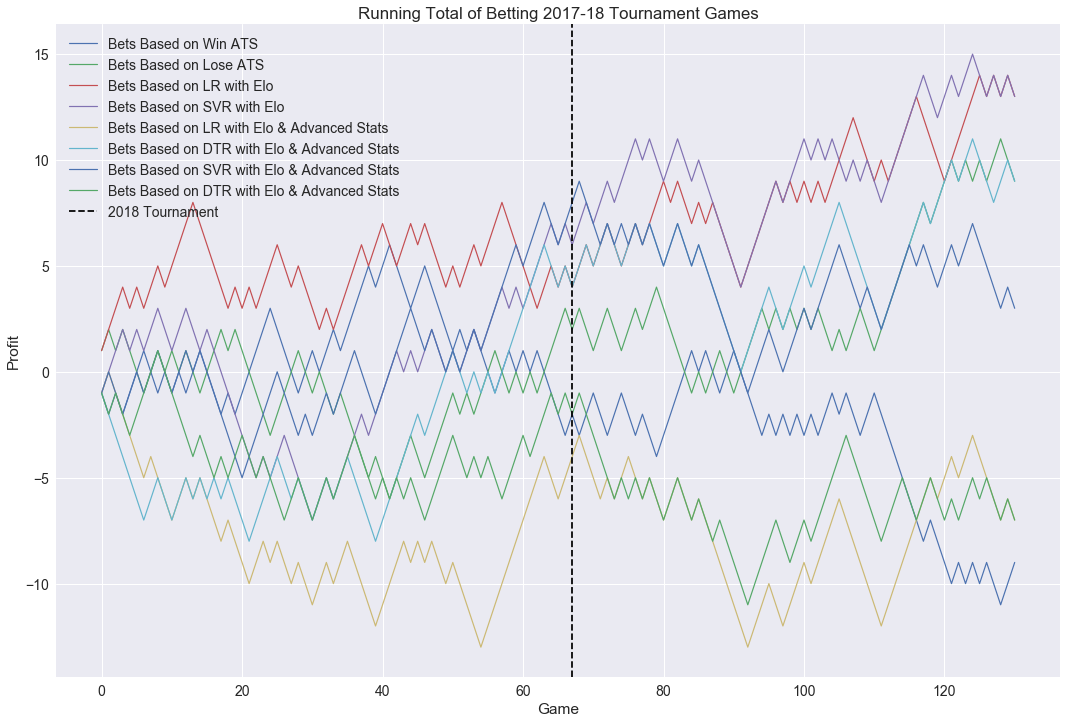

In [44]:
sns.set(font_scale=1.4)
plt.figure(figsize=(18,12))
plot_betting_strategy(odds_tourney[:131], x=np.arange(0,131), 
                      y_preds=['WinATS', 'LoseATS', 'PredBet', 'PredBetSVRBasic','PredBetAdvLR', 'PredBetDTR', 'PredBetSVR',
                              'PredBetDTRDefault'], 
                      labels=['Win ATS', 'Lose ATS', 'LR with Elo', 'SVR with Elo','LR with Elo & Advanced Stats', 
                              'DTR with Elo & Advanced Stats', 'SVR with Elo & Advanced Stats', 'DTR with Elo & Advanced Stats',
                             ],
                     linewidth=1.20,
                     alpha=1.0)
plt.savefig(cwd+"\\Documents\\bets_all.png")

### Alternative Workflow
Before, the workflow was:
1. Get stats for each team from each season.
2. Scale those stats using RobustScaler with respect to all of the season stats, where each row is a unique team and season.
3. Match those stats to the corresponding teams in the train/test matrix, tourney_matchups_scaled.
4. Train/Test using various regressors.

Below, I try a slightly different workflow:
1. Get stats for each team from each season
2. Match those stats to the corresponding teams in the train/test matrix, tourney_matchups
3. Scale those stats using RobustScaler
4. Train/Test using various regressors.

In [45]:
mses

{'DTR': 130.83362944936803,
 'DTRDefault': 269.55223880597015,
 'LRAdv': 132.29432032373012,
 'LRBasic': 123.72597937002105,
 'SVRAdv': 129.97175367539427,
 'SVRBasic': 124.15868725216995}

In [46]:
tourney_matchups.head()

,Season,WTeamID,LTeamID,WMargin,SeasonEloDiff,OffRtgdiff,DefRtgdiff,NetRtgdiff,AstRdiff,TORdiff,...,oAstRdiff,oTORdiff,oTSPdiff,oeFGPdiff,oFTARdiff,oTPARdiff,oORPdiff,oDRPdiff,oRPdiff,oPosdiff
0,2003,1421,1411,8,-32.749319,-0.000260,0.125524,-0.125784,-0.008846,0.013008,...,0.015066,-0.020723,0.032470,0.024351,0.059560,-0.043286,0.056104,0.012949,0.030010,-1.008905
1,2003,1112,1436,29,212.816233,0.083398,-0.042912,0.126309,0.009173,-0.018083,...,-0.001778,0.014079,-0.023912,-0.020695,-0.010087,-0.082627,0.052338,-0.014010,0.013179,10.374053
2,2003,1113,1272,13,-35.039513,0.043729,0.068577,-0.024848,-0.005714,0.006565,...,0.009399,0.008421,0.042091,0.039381,0.006043,-0.031739,-0.000045,-0.031277,-0.010731,-0.484634
3,2003,1141,1166,6,-190.338184,-0.042072,0.090221,-0.132294,-0.013436,0.048875,...,-0.010825,-0.015841,0.032011,0.026953,0.084708,-0.015372,0.019458,-0.019944,-0.007251,2.633710
4,2003,1143,1301,2,-53.846204,-0.020666,-0.022923,0.002258,0.003702,-0.011144,...,0.024768,-0.010842,-0.017933,-0.001493,-0.109216,0.042834,-0.010425,-0.013497,-0.009767,3.520927


In [47]:
feature_cols = [col if col != 'AdjNetRtgdiff' else 'NetRtgdiff' for col in scaled_cols]
feature_cols

['AstRdiff',
 'TORdiff',
 'eFGPdiff',
 'FTARdiff',
 'TPARdiff',
 'RPdiff',
 'Posdiff',
 'NetRtgdiff',
 'SeasonEloDiff']

In [48]:
X_train = RobustScaler().fit_transform(tourney_matchups.loc[tourney_matchups.Season < 2017, feature_cols].values)
y_train = RobustScaler().fit_transform(tourney_matchups.loc[tourney_matchups.Season < 2017, 'WMargin'].values.reshape(-1,1))
X_test = RobustScaler().fit_transform(tourney_matchups.loc[tourney_matchups.Season >= 2017, feature_cols].values)
y_true = RobustScaler().fit_transform(tourney_matchups.loc[tourney_matchups.Season >= 2017, 'WMargin'].values.reshape(-1,1))

In [49]:
odds_tourney_alt = odds_tourney.copy()

#### LR with Advanced Stats

Linear Regression with Advanced Stats MSE:  0.381643250903


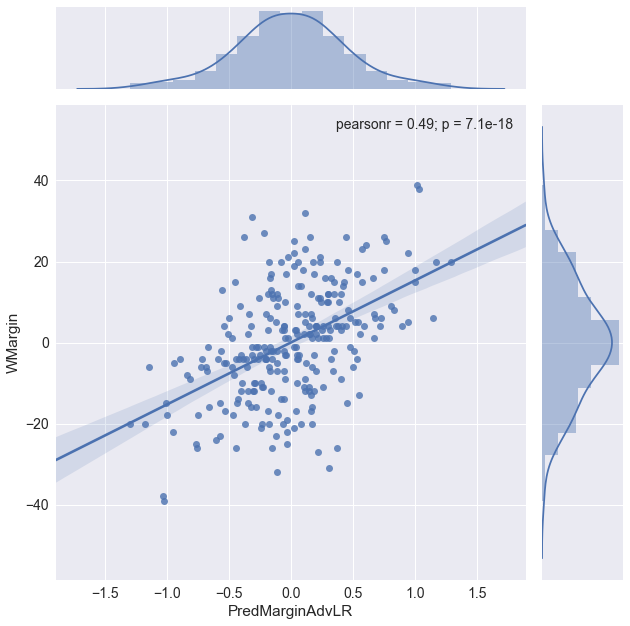

In [50]:
lr = lm.LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
odds_tourney_alt = simulate_betting(odds_tourney_alt, y_pred, 'AdvLR')
mse = mean_squared_error(y_true, y_pred)
model_name = 'AdvLRAlt'
mses[model_name] = mse
print("Linear Regression with Advanced Stats MSE: ", mse)
sns.set(font_scale=1.4)
sns.jointplot(data=odds_tourney_alt, x='PredMarginAdvLR', y='WMargin', kind='reg', size=9)

#### LSVR with Advanced Stats

Linear SVR with Advanced Stats MSE:  0.386368368558


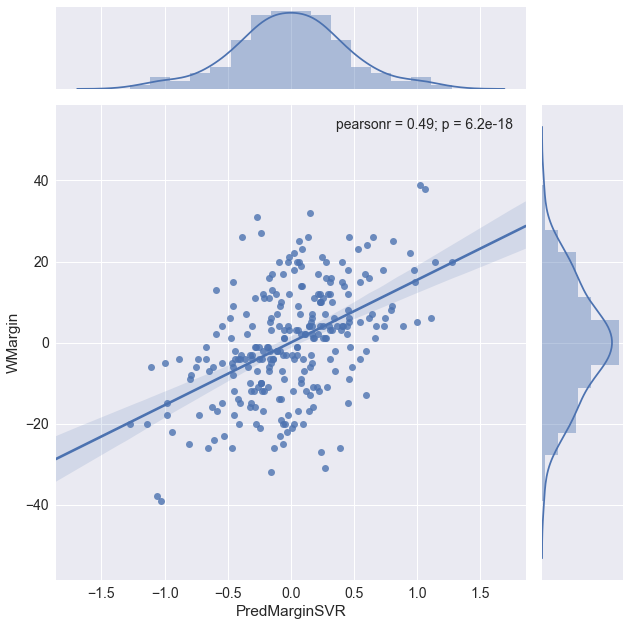

In [51]:
svr = LinearSVR(fit_intercept=False)
C_s =  np.logspace(start=-2, stop=2, num=5)

parameters = {'C':C_s}
reg = GridSearchCV(svr,
                  parameters,
                  scoring='neg_mean_squared_error'
                  )

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_true, y_pred)
model_name = 'AdvSVRAlt'
mses[model_name] = mse
print("Linear SVR with Advanced Stats MSE: ", mse)
odds_tourney_alt = simulate_betting(odds_tourney_alt, y_pred, 'SVR')

sns.jointplot(data=odds_tourney_alt, x='PredMarginSVR', y='WMargin', kind='reg', size=9)

#### DTR with Advanced Stats and Default Params

DTR MSE:  0.688735520262


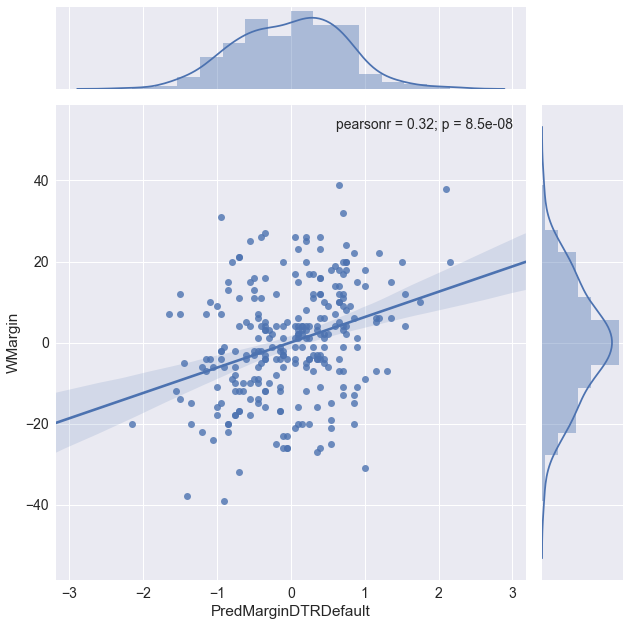

In [52]:
dtr = DecisionTreeRegressor(random_state=42018)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
odds_tourney_alt = simulate_betting(odds_tourney_alt, y_pred, 'DTRDefault')
mse = mean_squared_error(y_true, y_pred)
model_name = 'DTRDefaultAlt'
mses[model_name] = mse
print("DTR MSE: ", mse)
sns.jointplot(data=odds_tourney_alt, x='PredMarginDTRDefault', y='WMargin', kind='reg', size=9)

#### DTR with Advanced Stats and Grid Searching

DTR MSE:  0.369898691339


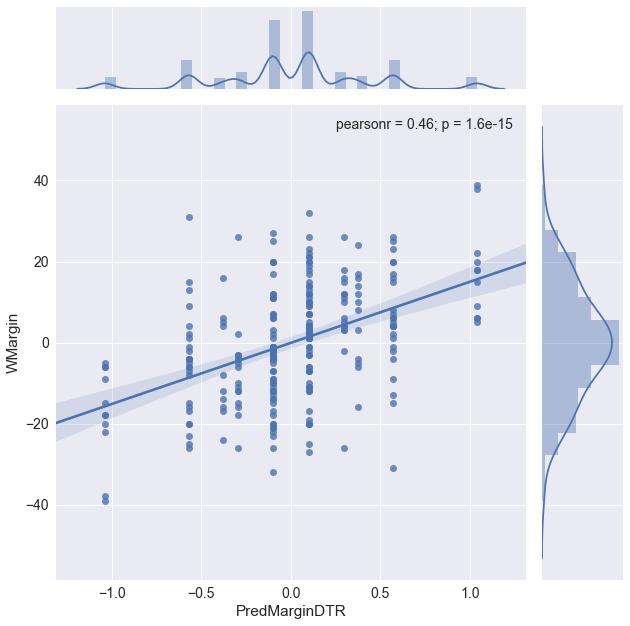

In [53]:
parameters = {'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(0.01,0.08,0.01),
             'max_depth':np.arange(2,5)}
dtr = DecisionTreeRegressor(random_state=42018)
reg = GridSearchCV(dtr,
                  parameters,
                  scoring='neg_mean_squared_error')

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
odds_tourney_alt = simulate_betting(odds_tourney_alt, y_pred, 'DTR')
mse = mean_squared_error(y_true, y_pred)
model_name = 'DTR'
mses[model_name] = mse
print("DTR MSE: ", mse)
sns.jointplot(data=odds_tourney_alt, x='PredMarginDTR', y='WMargin', kind='reg', size=9)

In [54]:
reg.best_params_

{'max_depth': 4,
 'min_samples_leaf': 0.040000000000000001,
 'min_samples_split': 2}

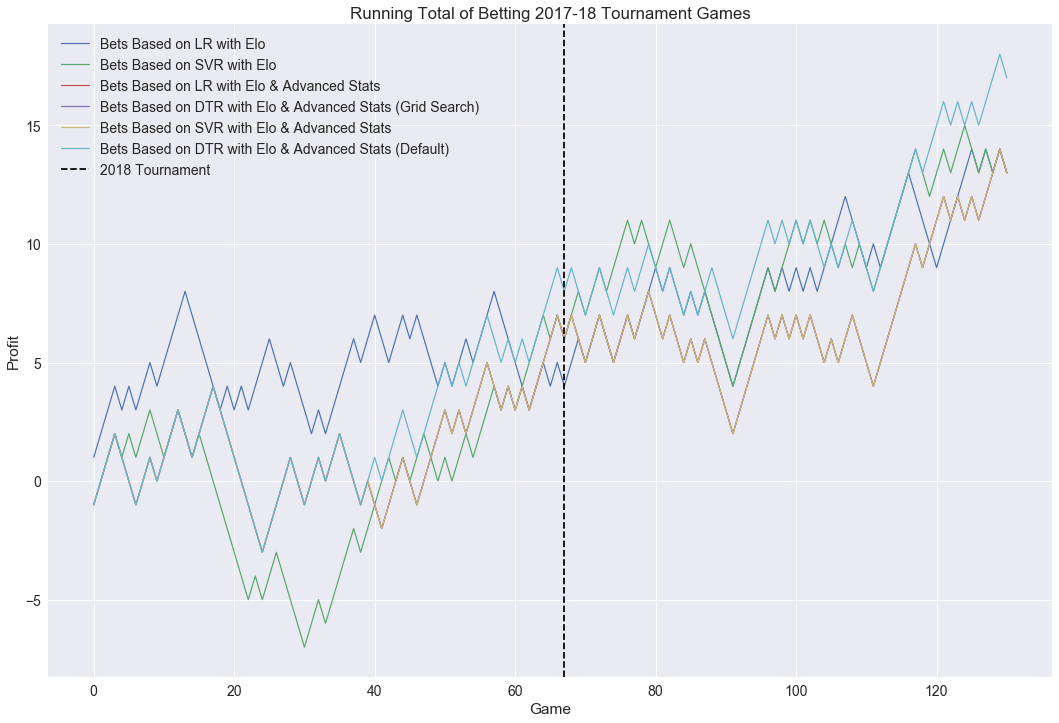

In [55]:
sns.set(font_scale=1.4)
plt.figure(figsize=(18,12))
plot_betting_strategy(odds_tourney_alt[:131], x=np.arange(0,131), 
                      y_preds=[
#                               'WinATS', 
#                               'LoseATS', 
                               'PredBet', 
                               'PredBetSVRBasic',
                               'PredBetAdvLR', 
                               'PredBetDTR', 
                               'PredBetSVR',
                              'PredBetDTRDefault'], 
                      labels=[
#                              'Win ATS', 
#                              'Lose ATS', 
                              'LR with Elo', 
                              'SVR with Elo',
                              'LR with Elo & Advanced Stats', 
                              'DTR with Elo & Advanced Stats (Grid Search)', 
                              'SVR with Elo & Advanced Stats', 
                              'DTR with Elo & Advanced Stats (Default)',
                             ],
                     linewidth=1.20,
                     alpha=1.0)

### Dimensionality Reduction
Below is the same workflow but with reducing X into 3 dimensions.

In [56]:
X = np.concatenate([X_train, X_test])
odds_tourney_red = odds_tourney.copy()

In [57]:
pca = PCA(3)
X_red = pca.fit_transform(X)
X_train = X_red[:len(X_train)]
X_test = X_red[len(X_train):]

In [58]:
pca.explained_variance_

array([ 1.74242713,  1.05091982,  0.61899837])

In [59]:
dict(list(zip(feature_cols, zip(*np.round(pca.components_,3)))))

{'AstRdiff': (0.375, -0.161, -0.29199999999999998),
 'FTARdiff': (-0.13700000000000001, 0.48299999999999998, -0.30599999999999999),
 'NetRtgdiff': (0.53900000000000003, 0.13500000000000001, -0.001),
 'Posdiff': (-0.0030000000000000001,
  0.23499999999999999,
  0.074999999999999997),
 'RPdiff': (0.26300000000000001, 0.53800000000000003, -0.051999999999999998),
 'SeasonEloDiff': (0.49199999999999999, 0.127, 0.27500000000000002),
 'TORdiff': (-0.32900000000000001, 0.315, -0.50900000000000001),
 'TPARdiff': (0.019, -0.501, -0.34999999999999998),
 'eFGPdiff': (0.35899999999999999, -0.10199999999999999, -0.59699999999999998)}

#### LR Reduced

Linear Regression MSE:  0.424144385747


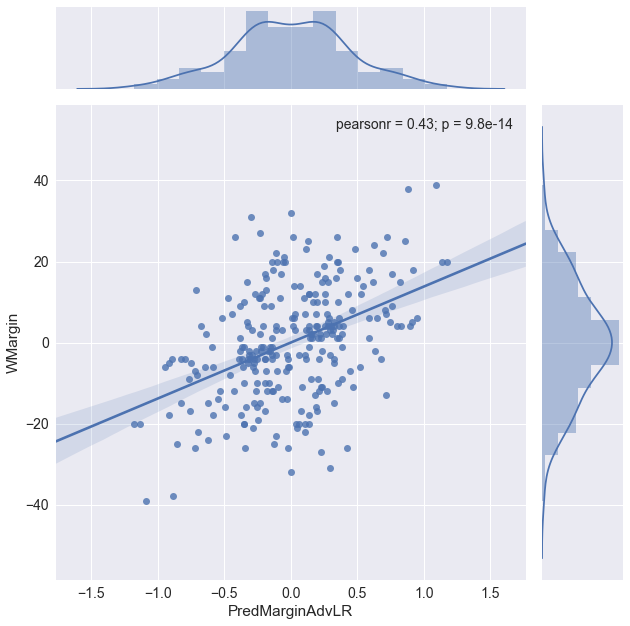

In [60]:
lr = lm.LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
odds_tourney_red = simulate_betting(odds_tourney_red, y_pred, 'AdvLR')
model_name = 'LRAdvRed'
mse = mean_squared_error(y_true, y_pred)
mses[model_name] = mse
print("Linear Regression MSE: ", mse)
sns.set(font_scale=1.4)
sns.jointplot(data=odds_tourney_red, x='PredMarginAdvLR', y='WMargin', kind='reg', size=9)

#### LSVR Reduced

Linear SVR with Advanced Stats MSE:  0.422747654481


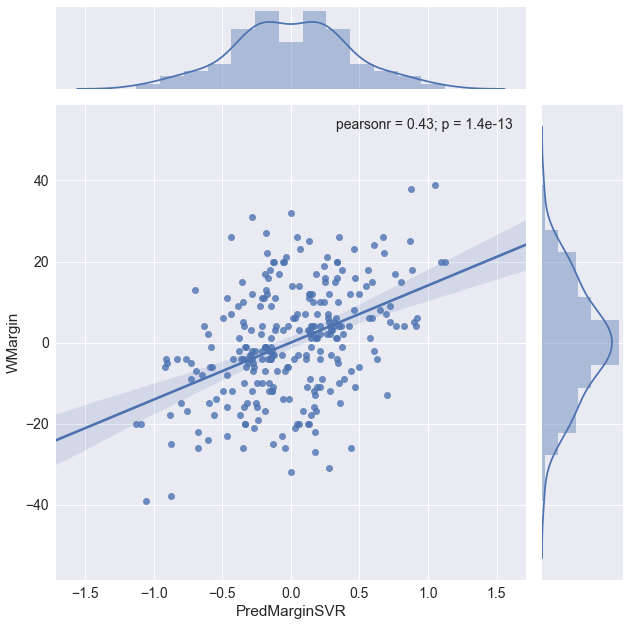

In [61]:
svr = LinearSVR(fit_intercept=False)
C_s =  np.logspace(start=-2, stop=2, num=5)

parameters = {'C':C_s}
reg = GridSearchCV(svr,
                  parameters,
                  scoring='neg_mean_squared_error'
                  )

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_true, y_pred)
model_name = 'SVRAdvRed'
mses[model_name] = mse
print("Linear SVR with Advanced Stats MSE: ", mse)
odds_tourney_red = simulate_betting(odds_tourney_red, y_pred, 'SVR')

sns.jointplot(data=odds_tourney_red, x='PredMarginSVR', y='WMargin', kind='reg', size=9)

#### DTR Default Reduced

DTR MSE:  0.805678592065


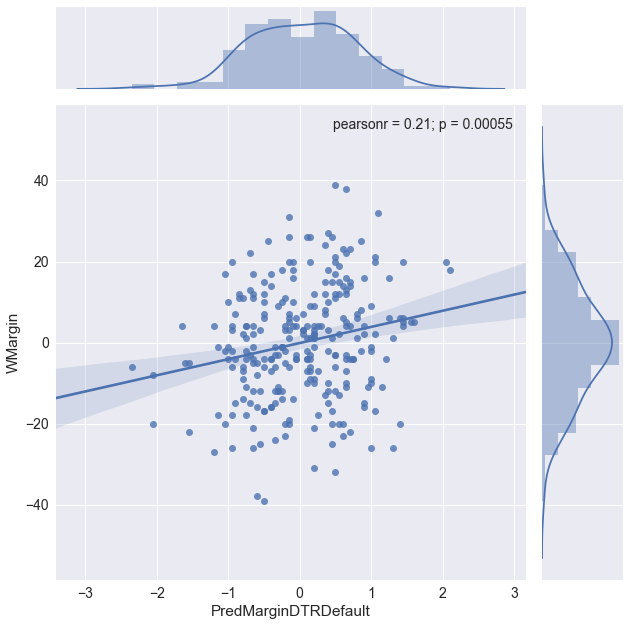

In [62]:
dtr = DecisionTreeRegressor(random_state=42018)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
odds_tourney_red = simulate_betting(odds_tourney_red, y_pred, 'DTRDefault')
mse = mean_squared_error(y_true, y_pred)
model_name = 'DTRDefaultRed'
mses[model_name] = mse
print("DTR MSE: ", mse)
sns.jointplot(data=odds_tourney_red, x='PredMarginDTRDefault', y='WMargin', kind='reg', size=9)

#### DTR With Grid Searching Reduced

DTR MSE:  0.463392379049


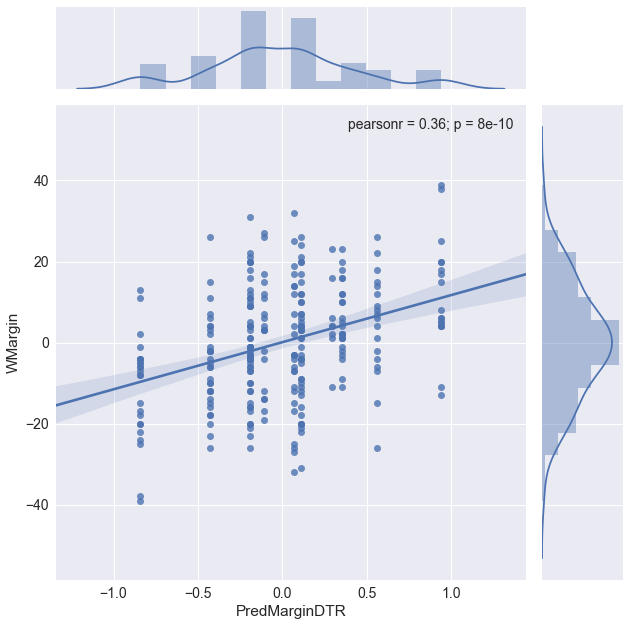

In [63]:
parameters = {'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(0.01,0.08,0.01),
             'max_depth':np.arange(2,5)}
dtr = DecisionTreeRegressor(random_state=42018)
reg = GridSearchCV(dtr,
                  parameters,
                  scoring='neg_mean_squared_error')

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
odds_tourney_red = simulate_betting(odds_tourney_red, y_pred, 'DTR')
mse = mean_squared_error(y_true, y_pred)
model_name = 'DTRRed'
mses[model_name] = mse
print("DTR MSE: ", mse)
sns.jointplot(data=odds_tourney_red, x='PredMarginDTR', y='WMargin', kind='reg', size=9)

In [64]:
reg.best_params_

{'max_depth': 4,
 'min_samples_leaf': 0.050000000000000003,
 'min_samples_split': 2}

In [65]:
odds_tourney_red.head()

,LTeamID,WTeamID,date,home,lineavg,WMargin,road,std,WinATS,LoseATS,...,PredMarginSVRBasic,PredBetSVRBasic,PredMarginAdvLR,PredBetAdvLR,PredMarginDTRDefault,PredBetDTRDefault,PredMarginDTR,PredBetDTR,PredMarginSVR,PredBetSVR
0,1448,1243,2017-03-14,Wake Forest,0.09,-7,Kansas St.,1.68,-1,1,...,4.936214,-1.0,-0.105716,1.0,0.65,-1.0,0.069444,1.0,-0.100450,1.0
1,1309,1291,2017-03-14,New Orleans,0.95,-1,Mount St. Marys,1.86,-1,1,...,0.035852,1.0,-0.207558,1.0,-0.25,1.0,-0.190032,1.0,-0.147531,1.0
2,1300,1413,2017-03-15,UC Davis,-2.33,4,NC Central,2.34,1,-1,...,-0.090992,1.0,-0.322909,1.0,0.10,1.0,-0.190032,1.0,-0.338302,1.0
3,1344,1425,2017-03-15,Providence,0.44,-4,USC,1.73,-1,1,...,-0.156771,1.0,0.211876,1.0,-0.40,1.0,0.351768,1.0,0.211184,1.0
4,1315,1112,2017-03-16,Arizona,16.59,18,North Dakota,2.70,1,-1,...,14.481100,-1.0,0.584747,-1.0,-0.10,-1.0,0.558411,-1.0,0.559954,-1.0


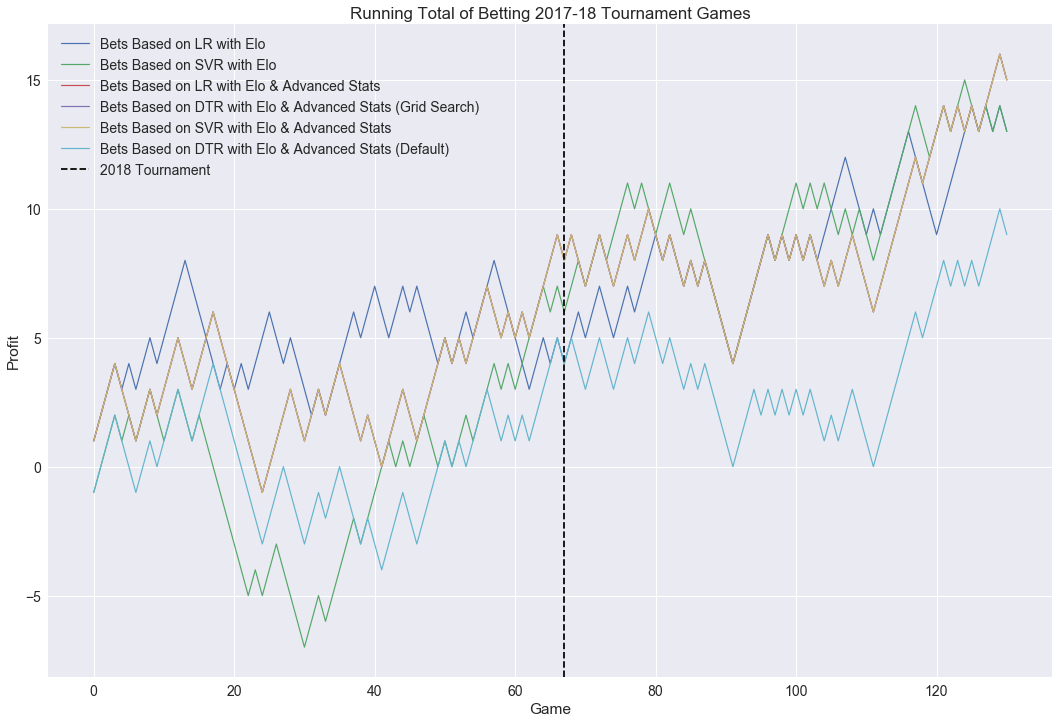

In [66]:
sns.set(font_scale=1.4)
plt.figure(figsize=(18,12))
plot_betting_strategy(odds_tourney_red[:131], x=np.arange(0,131), 
                      y_preds=[
#                              'WinATS', 
#                               'LoseATS', 
                               'PredBet', 
                               'PredBetSVRBasic',
                               'PredBetAdvLR', 
                               'PredBetDTR', 
                               'PredBetSVR',
                              'PredBetDTRDefault'], 
                      labels=[
#                          'Win ATS', 
#                              'Lose ATS', 
                              'LR with Elo', 
                              'SVR with Elo',
                              'LR with Elo & Advanced Stats', 
                              'DTR with Elo & Advanced Stats (Grid Search)', 
                              'SVR with Elo & Advanced Stats', 
                              'DTR with Elo & Advanced Stats (Default)',
                             ],
                     linewidth=1.20,
                     alpha=1.0)